This assignment seeks to explore the effects of reducing and not reducing data's dimensionality on the performance of logistic regression.



In [ ]:
# set up:
%matplotlib inline
import random
import matplotlib.pylab as plt

from PIL import Image
import numpy as np
from scipy.misc import imresize
import glob

import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

import time 

%matplotlib inline

# Data processing

(**#overfitting**) To avoid overfitting, I have used the following techniques:

1. Augment the data. The original data set has only 2508 samples. For each image, I cropped from it 1 or 2 pixels from all four sides and thus increase the size of the data set by 3. 


2. Keep the number of features reasonably small. It is because if the number of features is too much larger than the number of samples, the issue of overfit is more severe. I chose the image size to just $218\times 218$, when also increased the number of data points by means of augmentation, thus reduce the problem of overfitting. I could have augment the data further to the extent that the number of samples outnumbers the number of features, but I did not due to limited computational resources (my computer collapsed when I tried augmented the data to 8-fold). 


3. Apply regularization in the cost function. Regularization has the effect of shrinking the parameters towards 0 and thus prevents learning overly complex models, whose flexibility leads to overfitting.


4. Use cross validation to tune the parameter (the regularization strength) of the logistic regression classifier. I chose CV over the validation set approach (i.e., designating a fixed part of the training data as a validation data) because our data set is already very small. We we used the validation set approach, we will further shrink our training set, which may exacerbate the possible overfitting. We want to utilize all the training data we have. 

Processing code adapted from this [notebook](https://github.com/ostegm/resizing/blob/master/Resizing.ipynb?fbclid=IwAR1-jIhpdnew0hGPi1ICZTS7zcjo_JPeMUEx01VQR09NSFOb2lHNAP0_ojc)

In [1]:
size = 218

X_man = []
X_woman = []

for gender in ['man', 'woman']:
    fnames = list(glob.iglob(f'./{gender}/*.JPEG'))
    for fname in fnames:
        img = Image.open(fname)
        img_arr = np.array(img)
        resized = imresize(img_arr, (size, size))
        if resized.shape != (size, size, 3):
            continue
        if gender == 'man':
            X_man.append(resized)
        else:
            X_woman.append(resized)
        
        # crop to augment
        for crop_size in range(1,3):
            crop_specs = (crop_size, crop_size, 
                          img.width - crop_size, img.height - crop_size)
            crop_img = img.crop(crop_specs)
            img_arr = np.array(crop_img)
            resized = imresize(img_arr, (size, size))
            if gender == 'man':
                X_man.append(resized)
            else:
                X_woman.append(resized)
        img.close()
        

X_man, X_woman = np.stack(X_man, axis=0), np.stack(X_woman, axis=0)

NameError: name 'glob' is not defined

In [3]:
print(X_man.shape)
print(X_woman.shape)

(3726, 218, 218, 3)
(3798, 218, 218, 3)


In [4]:
y_man = np.array([0]*X_man.shape[0])
y_woman = np.array([1]*X_woman.shape[0])
y = np.concatenate((y_man, y_woman))
X = np.concatenate((X_man, X_woman))
X = np.reshape(X, (X.shape[0],-1))

In [5]:
print(X.shape)
print(y.shape)

(7524, 142572)
(7524,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Logistic Regression Using the Original Pixel Data

We use cross validation to tune the inverse of the regularization strength (`C`). I didn't tune the penalty type and fixed it to `l1` due to reasons of computational resource. It is not that the L2 penalty involves squares and the numbers may explode (because I can always normalize the data so that they have a small range). It is that it took too long just to finish one iteration. Maybe with ambler time I will attempt tuning this (and other params) as well. 

In [9]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
i = 0
best_accuracy = -1
best_C = 0
print('Running ...')
for C in [1/1e-3, 1/1e-1, 1, 1/1e1, 1/1e3]:
    clf = LogisticRegression(random_state=0, 
                       penalty='l1',
                       C=C)
    scores = model_selection.cross_val_score(clf, X_train, y_train, cv=3)
    if np.mean(scores) > best_accuracy:
        best_accuracy = np.mean(scores)
        best_C = C
    i += 1
    print('Finished %d/%d'%(i,5))
print('Finished')

Running ...
Finished 1/5
Finished 2/5
Finished 3/5
Finished 4/5
Finished 5/5
Finished


In [10]:
print('-'*50)
print('Best C:', best_C)
print('Val Accuracy:', best_accuracy)

--------------------------------------------------
Best C: 1
Val Accuracy: 0.9097821796612936


In [14]:
import time
start = time.time()
clf = LogisticRegression(random_state=0, 
                       penalty='l1',
                       C=best_C)
clf.fit(X_train, y_train)
end = time.time() - start

In [16]:
print('Time running:', end/60, 'mins')

Time running: 10.790315481026967 mins


In [19]:
preds = clf.predict(X_train)
acc = np.sum(preds==y_train)/len(y_train)
print('Training accuracy:', acc)

Training accuracy: 1.0


In [17]:
preds = clf.predict(X_test)
acc = np.sum(preds==y_test)/len(y_test)
print('Testing accuracy:', acc)

Testing accuracy: 0.9833887043189369


# Logistic Regression on the Reduced Representation Created Using PCA

In [29]:
# subtract the mean from the data
mean_X_train = np.mean(X_train, axis=0)
X_train_pca = X_train - mean_X_train

In [50]:
X_test_pca = X_test - mean_X_train

In [57]:
pca = PCA(n_components=10)
pca.fit(X_train_pca)
X_r = pca.transform(X_train_pca)
print(X_r.shape)

(6019, 10)


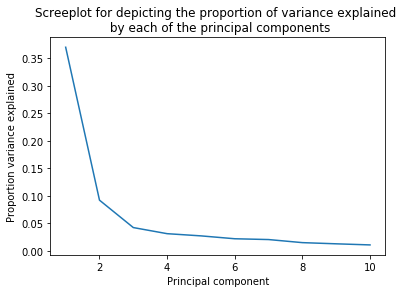

In [37]:
plt.plot(range(1,11), pca.explained_variance_ratio_)
plt.title('Screeplot for depicting the proportion of variance explained \n by each of the principal components')
plt.xlabel('Principal component')
plt.ylabel('Proportion variance explained')
plt.show()

ISLR says that we can eye-ball the scree plot above (**#dataviz**) and look for an elbow shape to pick the number of components to use. However, it further notes that if in a supervised setting, we can always cross validate the parameter. Below I did just that, but in a sloppy way, due to (again) terribly long time it requires to train the model. It is sloppy because I used cross validation, but fit the PCA to **ALL** the training data. An ideal version would be as follows: we have k folds of data, and in each iteration, we only fit the PCA to $k-1$ fold and used the fitted results to transform the other fold and feed it to the classifer to get the validation score. 

Therefore, what I did below is mostly for demonstration that we could cross validate the `n_comp`, but the methodology is errored. 

In [48]:
i = 0
best_accuracy_pca = -1
best_C_pca = 0
best_n_comp = -1
print('Running ...')
for n_comp in range(1,11):
    for C in [1/1e-3, 1/1e-1, 1, 1/1e1, 1/1e3]:
        clf = LogisticRegression(random_state=0, 
                           penalty='l1',
                           C=C)
        X_r_best = X_r[:,:n_comp]
        scores = model_selection.cross_val_score(clf, X_r_best, y_train, cv=10)
        if np.mean(scores) > best_accuracy_pca:
            best_n_comp = n_comp
            best_accuracy_pca = np.mean(scores)
            best_C_pca = C
        i += 1
        if i%5==0:
            print('Finished %d/%d'%(i,50))
print('Finished')

Running ...
Finished 5/50
Finished 10/50
Finished 15/50
Finished 20/50
Finished 25/50
Finished 30/50
Finished 35/50
Finished 40/50
Finished 45/50
Finished 50/50
Finished


In [49]:
print('-'*50)
print('Best number of components:', best_n_comp)
print('Best C:', best_C_pca)
print('Val Accuracy:', best_accuracy_pca)

--------------------------------------------------
Best number of components: 9
Best C: 1000.0
Val Accuracy: 0.6501110036977887


In [53]:
start = time.time()
clf = LogisticRegression(random_state=0, 
                       penalty='l1',
                       C=best_C_pca)
clf.fit(X_r[:,:best_n_comp], y_train)
end = time.time() - start
print('Running time:', end,'secs')

Running time: 0.006350040435791016 secs


In [54]:
preds = clf.predict(X_r[:,:best_n_comp])
acc = np.sum(preds==y_train)/len(y_train)
print('Training accuracy:', acc)

Training accuracy: 0.648612726366506


In [58]:
X_r_test = pca.transform(X_test_pca)

In [59]:
preds = clf.predict(X_r_test[:,:best_n_comp])
acc = np.sum(preds==y_test)/len(y_test)
print('Testing accuracy:', acc)

Testing accuracy: 0.6478405315614618


# Logistic Regression on the Reduced Representation Created Using LDA

In [7]:
lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(X_train, y_train)
X_r_lda = lda.transform(X_train)
print(X_r_lda.shape)

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(6019, 1)


In [22]:
i = 0
best_accuracy_lda = -1
best_C_lda = 0
print('Running ...')
for C in [1/1e-3, 1/1e-1, 1, 1/1e1, 1/1e3]:
    clf = LogisticRegression(random_state=0, 
                       penalty='l1',
                       C=C)
    scores = model_selection.cross_val_score(clf, X_r_lda, y_train, cv=10)
    if np.mean(scores) > best_accuracy_lda:
        best_accuracy_lda = np.mean(scores)
        best_C_lda = C
    i += 1
    print('Finished %d/%d'%(i,5))
print('Finished')

Running ...
Finished 1/5
Finished 2/5
Finished 3/5
Finished 4/5
Finished 5/5
Finished


In [12]:
print('-'*50)
print('Best C:', best_C_lda)
print('Val Accuracy:', best_accuracy_lda)

--------------------------------------------------
Best C: 10.0
Val Accuracy: 0.9998338870431894


In [16]:
start = time.time()
clf = LogisticRegression(random_state=0, 
                       penalty='l1',
                       C=best_C_lda)
clf.fit(X_r_lda, y_train)
end = time.time() - start
print('Running time:', end,'secs')

Running time: 0.0059049129486083984 secs


In [17]:
preds = clf.predict(X_r_lda)
acc = np.sum(preds==y_train)/len(y_train)
print('Training accuracy:', acc)

Training accuracy: 0.9996677188901811


In [19]:
X_r_lda_test = lda.transform(X_test)

In [20]:
preds = clf.predict(X_r_lda_test)
acc = np.sum(preds==y_test)/len(y_test)
print('Testing accuracy:', acc)

Testing accuracy: 0.9315614617940199


# Model Metric 

I chose accuracy to evaluate the classifier's performance because:

1. There is no obvious reason why one would try to avoid one type of error more than the other. In this context, we would feel as bad when we missclassify a woman's clothe as when we do a man's.

2. The classes are balanced. There are 3726 samples for man clothes, and 3798 samples for woman clothes. The ratio is almost 50/50. That said, when the classifer achieve an impressive accuracy, we know that it is vertainly not due to lazily predicting everything to one class, as in cases with super imbalanced data sets. 

# Interpreting the results

## Original Pixel Data

The training accuracy is at a perfect level ($100\%$). One may suspect that it is suffering heavy overfit due to the fact the number of features is much smaller than the number of observations, but the test accuracy negates that. It is nearly just as good ($98.3\%$), suggesting no variance problem. The testing accuracy is also much better than random guessing (which would be one of $50\%$). This is a reasonably good model on this kind of data.

## Using PCA

The training accuracy is much worse than that of the case above ($64.8\%$). This is the problem of high bias. The testing accuracy is just slightly under the training accuracy ($64.7\%$), suggesting that there is no overfit/ high variance problem. However, given that these accuracies is way lower than the optimal (Bayes) performance (the human performance), which should be very close to $100\%$, the model suffers heavily with underfitting.

One possible explanation for this poor performance is that in dimensionality reduction using PCA, it is unsupervised and thus only tries to maximize the variation in the projected data points, the goal of which may be an equivalent of having much overlap between the two classes in the reduced data space. This large inseparability may have led to the poor classfication performance. That said, we would expect a supervised dimension reduction techniques like LDA, which takes into account the labels in data, perform better.

## Using LDA

As expected, the training and testing accuracies are a vast improvement from those in the PCA case ($99.9\%$ and $93.1\%$, respectively.) The little gap between the two accuracies also shows that the model does not overfit. The little difference between the accuracies and the optimal performance ($100\%$) shows that the model has low bias. Therefore, it is a better model than PCA, but not as good as when fit with the original data set.

However, the number of components for LDA is not chosen in a proper way. Ideally, this should have also been cross validated, but I just picked $1$ because I had tried with larger quantities and the notebook collapsed. Perhaps we could have seen better performance with LDA if this had been done properly.

## Synthesis

No models/cases overfits.

The logsitic regression used on the original (non-reduced data set) has the best performance. Its main disadvantage is the super long training time (about $10$ minutes). However, given that 1) the testing time is roughly the same (the output was printed almost instantaneously) for the three cases and 2) we don't care as much about the training time (as long as it's feasible) as we do the testing time in practice (we would be happy to incubate the model for a long period of time as long as it performs reasonable fast and accurately in testing phase), the first classifer is the most recommendable. The catch is that there is still a possible outperformance of the LDA over the original-data case if the number of components used in the LDA has been properly tuned. 



